## Importing libraries

In [760]:
# loading data
import urllib.request

# data manipulation
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
# enable interactive plot in the notebook
%matplotlib notebook

# machine learning methods
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

## Loading and formatting the data

In [761]:
id_num = ['85065', '85012', '85064', '85030',
      '85054', '95040']
id_n = '85054'

In [762]:
# API URL to underground water levels in Ljubljana aquifer
# station with id 85076 is 1279238400Lj - RTV (0261) Ljubljansko polje
url = "http://atena.ijs.si:8080/CollectorAPIServer/undergroundWater?station_id=" + id_n;
jsonStr = urllib.request.urlopen(url).read().decode('utf-8');
df = pd.read_json(jsonStr);

# converting unix timestamp to date-time object
df['Date'] = df['LastUpdatedEpoch'];
df['Date'] = pd.to_datetime(df['Date'], unit='ms');

# remove unneccessary fields
df.drop('LastUpdated', 1, inplace=True);
df.drop('LastUpdatedEpoch', 1, inplace=True);
df.drop('Region_id', 1, inplace=True);
df.drop('Region_name', 1, inplace=True);
df.drop('Station_id', 1, inplace=True);
df.drop('Station_name', 1, inplace=True);
df.drop('SystemCodeNumber', 1, inplace=True);

## Checking loaded data

In [763]:
# string/tabular view
# len(jsonStr), jsonStr[0:100] and df[0:5]
df[0:5]

Value       Date
0  278.562 2001-01-01
1  278.599 2001-01-02
2  278.620 2001-01-03
3  278.628 2001-01-04
4  278.630 2001-01-05

<IPython.core.display.Javascript object>


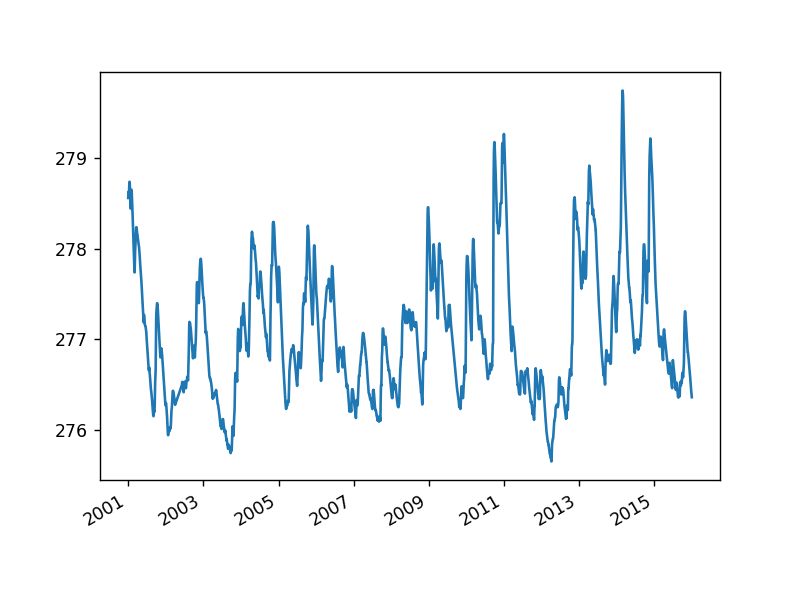

In [764]:
# plotting the data
# format date axis
fig, ax = plt.subplots(); fig.autofmt_xdate();
# plot
ax.plot(df['Date'], df['Value']);
# show plot
plt.show();

## Loading some additional data for modeling (weather)

In [765]:
pd.set_option('display.max_rows', 5000)
df['Date']

0      2001-01-01
1      2001-01-02
2      2001-01-03
3      2001-01-04
4      2001-01-05
5      2001-01-06
6      2001-01-07
7      2001-01-08
8      2001-01-09
9      2001-01-10
10     2001-01-11
11     2001-01-12
12     2001-01-13
13     2001-01-14
14     2001-01-15
15     2001-01-16
16     2001-01-17
17     2001-01-18
18     2001-01-19
19     2001-01-20
20     2001-01-21
21     2001-01-22
22     2001-01-23
23     2001-01-24
24     2001-01-25
25     2001-01-26
26     2001-01-27
27     2001-01-28
28     2001-01-29
29     2001-01-30
30     2001-01-31
31     2001-02-01
32     2001-02-02
33     2001-02-03
34     2001-02-04
35     2001-02-05
36     2001-02-06
37     2001-02-07
38     2001-02-08
39     2001-02-09
40     2001-02-10
41     2001-02-11
42     2001-02-12
43     2001-02-13
44     2001-02-14
45     2001-02-15
46     2001-02-16
47     2001-02-17
48     2001-02-18
49     2001-02-19
50     2001-02-20
51     2001-02-21
52     2001-02-22
53     2001-02-23
54     2001-02-24
55     200

In [766]:
# API URL to underground water levels in Ljubljana aquifer
# station with id 85076 is 1279238400Lj - RTV (0261) Ljubljansko polje
url = "http://atena.ijs.si:8080/CollectorAPIServer/weather?time_from=31/12/2009&time_to=01/01/2017&city=Ljubljana";
jsonStr = urllib.request.urlopen(url).read().decode('utf-8');
dw = pd.read_json(jsonStr);

# converting unix timestamp to date-time object
dw['Date'] = dw['LastUpdatedEpoch'];
dw['Date'] = pd.to_datetime(dw['Date'] + 2 * 60 * 60 * 1000, unit='ms').dt.round("1d");
dw.set_index('Date', inplace=True);

dw.drop('City', 1, inplace=True);
dw.drop('LastUpdated', 1, inplace=True);
dw.drop('LastUpdatedEpoch', 1, inplace=True);
dw.drop('Sensor_id', 1, inplace=True);
dw.drop('Sensor_name', 1, inplace=True);
dw.drop('SystemCodeNumber', 1, inplace=True);


In [767]:
dw[0:5]

CloudCover  New_snow_blanket  Percipitation  Snow_blanket  \
Date                                                                    
2010-01-01          97                 0           13.8             0   
2010-01-02         100                 0            4.6             0   
2010-01-03           7                 0            7.9             0   
2010-01-04          77                 0            0.0             0   
2010-01-05         100                10            5.8            10   

            Sun_duration  TemperatureAvg  TemperatureMax  TemperatureMin  
Date                                                                      
2010-01-01           0.0             6.9             7.7             5.5  
2010-01-02           0.0             2.5             6.7             0.7  
2010-01-03           8.0            -0.5             3.4            -2.6  
2010-01-04           0.8            -3.3            -1.6            -6.4  
2010-01-05           0.0            -1.5            -0.5            -2.3

## Data Fusion

In [768]:
# make date a key in our data
df.set_index('Date', inplace=True);

In [769]:
df[0:5]

Value
Date               
2001-01-01  278.562
2001-01-02  278.599
2001-01-03  278.620
2001-01-04  278.628
2001-01-05  278.630

In [770]:
# generate fused dataset
ds = pd.concat([df, dw], axis=1);

In [771]:
ds = ds.loc['2010-01-01':'2015-01-01']

In [772]:
# let's check it
ds[0:10]

Value  CloudCover  New_snow_blanket  Percipitation  Snow_blanket  \
Date                                                                            
2010-01-01  277.76        97.0               0.0           13.8           0.0   
2010-01-02  277.80       100.0               0.0            4.6           0.0   
2010-01-03  277.83         7.0               0.0            7.9           0.0   
2010-01-04  277.87        77.0               0.0            0.0           0.0   
2010-01-05  277.90       100.0              10.0            5.8          10.0   
2010-01-06  277.92       100.0               9.0           10.4          18.0   
2010-01-07  277.92       100.0               6.0            4.4          20.0   
2010-01-08  277.92       100.0               1.0            1.7          16.0   
2010-01-09  277.92       100.0              28.0           38.6          44.0   
2010-01-10  277.92       100.0               2.0            7.8          36.0   

            Sun_duration  TemperatureAvg  TemperatureMax  TemperatureMin  
Date                                                                      
2010-01-01           0.0             6.9             7.7             5.5  
2010-01-02           0.0             2.5             6.7             0.7  
2010-01-03           8.0            -0.5             3.4            -2.6  
2010-01-04           0.8            -3.3            -1.6            -6.4  
2010-01-05           0.0            -1.5            -0.5            -2.3  
2010-01-06           0.0            -0.7             0.5            -2.0  
2010-01-07           0.0             0.6             1.2            -0.6  
2010-01-08           0.0            -0.2             0.7            -0.5  
2010-01-09           0.0             0.7             1.5            -0.5  
2010-01-10           0.0             0.8             2.4             0.4

# .........

In [773]:
ds['DValue'] = ds['Value'] - ds['Value'].shift(1)

In [774]:
#dnew = ds
#for i in range(26):
#    dnew['Sun_duration' + '_shift_' + str(i)+'d'] = ds['Sun_duration'].shift(i)
#for i in range(50,101,10):
#    dnew['Sun_duration' + '_shift_' + str(i)+'d'] = ds['Sun_duration'].shift(i)

In [775]:
#shift of data for n days
def shift_of_data(string, data, new_data):
    for i in range(26):
        new_data[string + '_shift_' + str(i)+'d'] = data[string].shift(i)
    for i in range(30,101,10):
        new_data[string + '_shift_' + str(i)+'d'] = data[string].shift(i)

In [776]:
import copy
dnew = copy.deepcopy(ds)

data_names = ['CloudCover', 'New_snow_blanket', 'Percipitation','Snow_blanket',
              'Sun_duration', 'TemperatureAvg', 'TemperatureMax', 'TemperatureMin']

for string in data_names:
    shift_of_data(string, ds, dnew)

In [777]:
dnew

Value  CloudCover  New_snow_blanket  Percipitation  Snow_blanket  \
Date                                                                            
2010-01-01  277.76        97.0               0.0           13.8           0.0   
2010-01-02  277.80       100.0               0.0            4.6           0.0   
2010-01-03  277.83         7.0               0.0            7.9           0.0   
2010-01-04  277.87        77.0               0.0            0.0           0.0   
2010-01-05  277.90       100.0              10.0            5.8          10.0   
2010-01-06  277.92       100.0               9.0           10.4          18.0   
2010-01-07  277.92       100.0               6.0            4.4          20.0   
2010-01-08  277.92       100.0               1.0            1.7          16.0   
2010-01-09  277.92       100.0              28.0           38.6          44.0   
2010-01-10  277.92       100.0               2.0            7.8          36.0   
2010-01-11  277.91       100.0               0.0            0.0          30.0   
2010-01-12  277.90        97.0               1.0            1.5          26.0   
2010-01-13  277.89       100.0               2.0            1.2          23.0   
2010-01-14  277.88       100.0               0.0            0.0          23.0   
2010-01-15  277.86       100.0               0.0            0.2          23.0   
2010-01-16  277.84        93.0               0.0            0.0          23.0   
2010-01-17  277.83        80.0               0.0            0.0          22.0   
2010-01-18  277.81        77.0               2.0            1.9          24.0   
2010-01-19  277.79       100.0               0.0            0.0          23.0   
2010-01-20  277.77        43.0               0.0            0.0          23.0   
2010-01-21  277.75       100.0               0.0            0.0          21.0   
2010-01-22  277.72       100.0               3.0            1.6          23.0   
2010-01-23  277.70       100.0               0.0            0.0          23.0   
2010-01-24  277.67       100.0               0.0            0.0          23.0   
2010-01-25  277.64       100.0               0.0            0.0          22.0   
2010-01-26  277.60        90.0               0.0            0.2          21.0   
2010-01-27  277.56        43.0               1.0            0.6          21.0   
2010-01-28  277.53        67.0               0.0            0.0          20.0   
2010-01-29  277.51        73.0               0.0            0.0          20.0   
2010-01-30  277.48       100.0               9.0            7.4          28.0   
2010-01-31  277.44        83.0              21.0           15.0          48.0   
2010-02-01  277.41        37.0               0.0            0.1          43.0   
2010-02-02  277.37        70.0               0.0            0.0          42.0   
2010-02-03  277.34        70.0               0.0            0.0          38.0   
2010-02-04  277.30        97.0               0.0            0.0          32.0   
2010-02-05  277.27       100.0               0.0            0.1          25.0   
2010-02-06  277.25       100.0               0.0           13.1          22.0   
2010-02-07  277.22       100.0               0.0            0.5          20.0   
2010-02-08  277.21       100.0               0.0            0.0          19.0   
2010-02-09  277.20       100.0               0.0            0.0          18.0   
2010-02-10  277.18       100.0               3.0            1.8          21.0   
2010-02-11  277.16       100.0              21.0           18.3          41.0   
2010-02-12  277.14       100.0               3.0            3.2          43.0   
2010-02-13  277.11        37.0               0.0            0.1          41.0   
2010-02-14  277.09       100.0               0.0            0.0          36.0   
2010-02-15  277.07        97.0               0.0            0.2          33.0   
2010-02-16  277.05        70.0               0.0            0.0          32.0   
2010-02-17  277.03        87.0              

In [778]:
dnew.corr()

Value  CloudCover  New_snow_blanket  \
Value                        1.000000    0.263928          0.104551   
CloudCover                   0.263928    1.000000          0.142080   
New_snow_blanket             0.104551    0.142080          1.000000   
Percipitation                0.015502    0.240523          0.162416   
Snow_blanket                 0.149837    0.204792          0.552036   
Sun_duration                -0.325545   -0.879486         -0.143944   
TemperatureAvg              -0.376846   -0.420237         -0.213110   
TemperatureMax              -0.396490   -0.529976         -0.221492   
TemperatureMin              -0.332173   -0.205513         -0.189670   
DValue                       0.023662    0.121494         -0.026541   
CloudCover_shift_0d          0.263928    1.000000          0.142080   
CloudCover_shift_1d          0.271128    0.603422          0.154454   
CloudCover_shift_2d          0.280358    0.428934          0.095426   
CloudCover_shift_3d          0.290497    0.324331          0.093803   
CloudCover_shift_4d          0.299514    0.273099          0.072797   
CloudCover_shift_5d          0.306488    0.238201          0.078568   
CloudCover_shift_6d          0.312840    0.222282          0.073142   
CloudCover_shift_7d          0.318433    0.190783          0.071257   
CloudCover_shift_8d          0.322312    0.190404          0.064360   
CloudCover_shift_9d          0.325742    0.192444          0.061799   
CloudCover_shift_10d         0.329128    0.201115          0.076260   
CloudCover_shift_11d         0.332325    0.207258          0.083161   
CloudCover_shift_12d         0.336211    0.208523          0.094045   
CloudCover_shift_13d         0.339416    0.232605          0.066182   
CloudCover_shift_14d         0.342396    0.215728          0.083967   
CloudCover_shift_15d         0.344341    0.223923          0.092008   
CloudCover_shift_16d         0.346283    0.210314          0.080837   
CloudCover_shift_17d         0.347755    0.228911          0.080798   
CloudCover_shift_18d         0.349313    0.213634          0.082693   
CloudCover_shift_19d         0.350771    0.218929          0.079636   
CloudCover_shift_20d         0.352329    0.194212          0.089390   
CloudCover_shift_21d         0.354302    0.169626          0.082404   
CloudCover_shift_22d         0.356027    0.134346          0.070792   
CloudCover_shift_23d         0.357775    0.110251          0.071827   
CloudCover_shift_24d         0.358923    0.104508          0.056075   
CloudCover_shift_25d         0.358981    0.085774          0.092527   
CloudCover_shift_30d         0.346033    0.144308          0.103137   
CloudCover_shift_40d         0.323837    0.171291          0.096712   
CloudCover_shift_50d         0.311473    0.091285          0.007464   
CloudCover_shift_60d         0.299048    0.089167          0.079450   
CloudCover_shift_70d         0.260495    0.033981          0.061002   
CloudCover_shift_80d         0.198270    0.006775          0.074303   
CloudCover_shift_90d         0.163683   -0.023770          0.022231   
CloudCover_shift_100d        0.141682    0.002123          0.037131   
New_snow_blanket_shift_0d    0.104551    0.142080          1.000000   
New_snow_blanket_shift_1d    0.102904    0.095742          0.265859   
New_snow_blanket_shift_2d    0.101199    0.089664          0.193563   
New_snow_blanket_shift_3d    0.099455    0.100937          0.149120   
New_snow_blanket_shift_4d    0.097788    0.123121          0.113164   
New_snow_blanket_shift_5d    0.095684    0.116768          0.053588   
New_snow_blanket_shift_6d    0.095868    0.100336          0.020072   
New_snow_blanket_shift_7d    0.097025    0.079542          0.015413   
New_snow_blanket_shift_8d    0.098897    0.057689          0.006573   
New_snow_blanket_shift_9d    0.101752    0.052181          0.037560   
New_snow_blanket_shift_10d   0.104888    0.088985          0.045380   
New_snow_blanket_shift_11d   0.107995    0.075357       

In [779]:
#correlation for shifts
#plt.matshow(dnew.corr())

In [780]:
#average for last n days
def average_last_n_days(string, data, new_data):
    for i in range(26):
        new_data[string + '_average_' + str(i)+'d'] = data[string].rolling(i).sum()/i
    for i in range(30,101,10):
        new_data[string + '_average_' + str(i)+'d'] = data[string].rolling(i).sum()/i

In [781]:
#data_names = ['CloudCover', 'New_snow_blanket', 'Percipitation','Snow_blanket',
#              'Sun_duration', 'TemperatureAvg', 'TemperatureMax', 'TemperatureMin']

#dnew2 = copy.deepcopy(ds)
for string in data_names:
    average_last_n_days(string, ds, dnew)  

In [782]:
#difference snow blanket
for i in range(26):
    dnew['Snow_blanket' + '_dif_' + str(i)+'d'] = ds['Snow_blanket'] - ds['Snow_blanket'].shift(i)
for i in range(30,101,10):
    dnew['Snow_blanket' + '_dif_' + str(i)+'d'] = ds['Snow_blanket'] - ds['Snow_blanket'].shift(i)

In [783]:
#dnew2.corr()

<IPython.core.display.Javascript object>


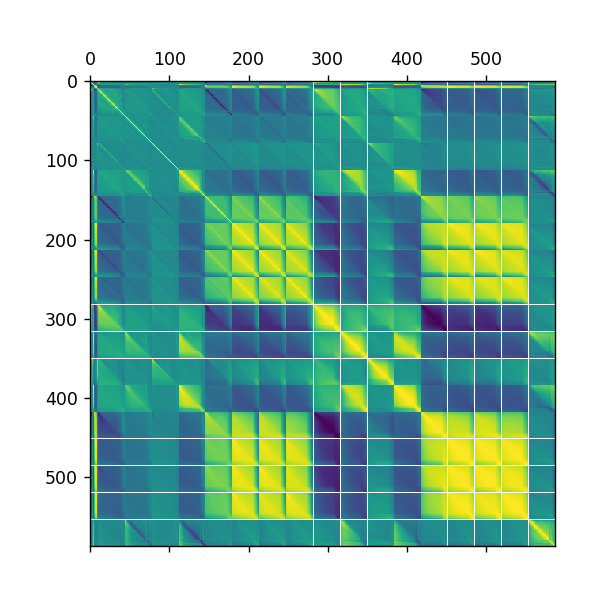

In [784]:
# correlation for shifts and average
plt.matshow(dnew.corr())

In [785]:
dnew.corr()['DValue']

Value                            0.023662
CloudCover                       0.121494
New_snow_blanket                -0.026541
Percipitation                    0.311011
Snow_blanket                    -0.076258
Sun_duration                    -0.125398
TemperatureAvg                  -0.045543
TemperatureMax                  -0.061095
TemperatureMin                  -0.000261
DValue                           1.000000
CloudCover_shift_0d              0.121494
CloudCover_shift_1d              0.175005
CloudCover_shift_2d              0.219097
CloudCover_shift_3d              0.225596
CloudCover_shift_4d              0.201968
CloudCover_shift_5d              0.176568
CloudCover_shift_6d              0.156372
CloudCover_shift_7d              0.117648
CloudCover_shift_8d              0.094645
CloudCover_shift_9d              0.089476
CloudCover_shift_10d             0.086630
CloudCover_shift_11d             0.078200
CloudCover_shift_12d             0.066642
CloudCover_shift_13d             0

In [786]:
# sort for corelation with 'DValue' from max to min
dsort = dnew.corr().sort_values(['DValue'], ascending = False)

In [787]:
pd.set_option('display.max_rows', 1000)
dsort['DValue']

DValue                           1.000000
Percipitation_average_6d         0.765166
Percipitation_average_7d         0.758988
Percipitation_average_5d         0.757264
Percipitation_average_8d         0.747949
Percipitation_average_9d         0.736422
Percipitation_average_4d         0.726997
Percipitation_average_10d        0.724142
Percipitation_average_11d        0.714754
Percipitation_average_12d        0.704956
Percipitation_average_13d        0.692840
Percipitation_average_14d        0.681014
Percipitation_average_15d        0.667490
Percipitation_average_3d         0.657689
Percipitation_average_16d        0.651431
Percipitation_average_17d        0.635769
Percipitation_average_18d        0.623457
Percipitation_average_19d        0.613264
Percipitation_average_20d        0.602480
Percipitation_average_21d        0.592087
Percipitation_average_22d        0.580626
Percipitation_average_23d        0.567346
Percipitation_average_24d        0.553690
Percipitation_average_25d        0

<IPython.core.display.Javascript object>


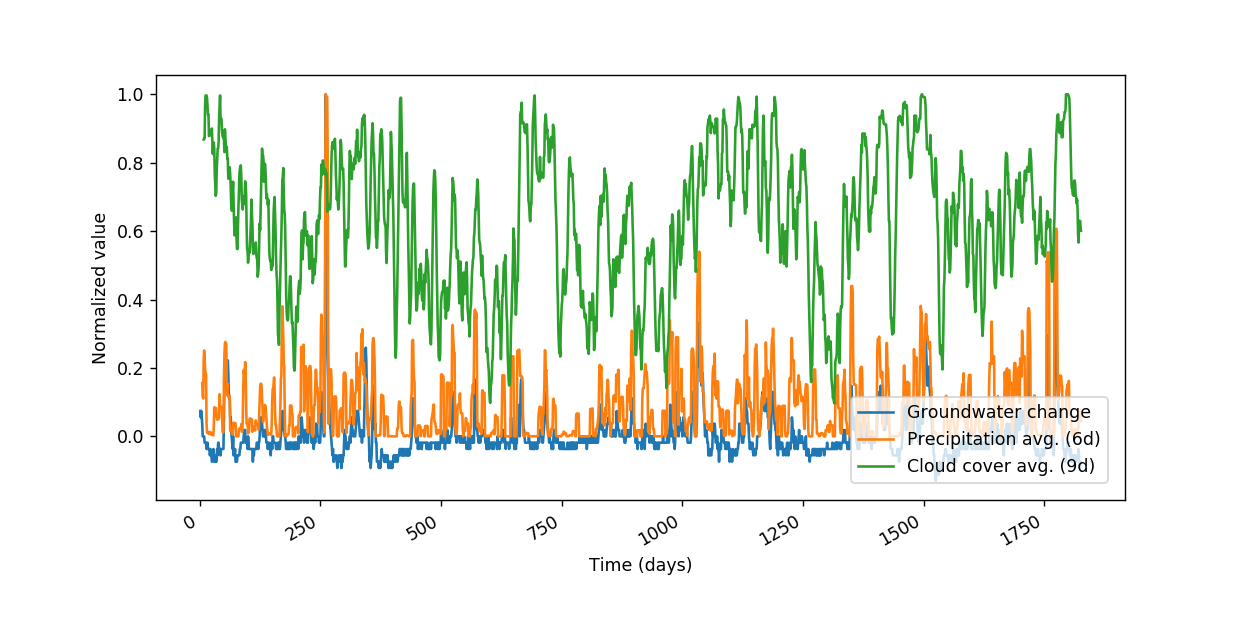

In [788]:
# ploted corelated quantities
fig, ax = plt.subplots(); fig.autofmt_xdate();
fig.set_size_inches(10, 5)
ax.plot(range(len(dnew['DValue'])), dnew['DValue'] / np.max(np.abs(dnew['DValue']),axis=0), label="Groundwater change");
ax.plot(range(len(dnew['DValue'])), dnew['Percipitation_average_6d'] / np.max(np.abs(dnew['Percipitation_average_6d']),axis=0), label="Precipitation avg. (6d)");
ax.plot(range(len(dnew['DValue'])), dnew['CloudCover_average_9d'] / np.max(np.abs(dnew['CloudCover_average_9d']),axis=0), label="Cloud cover avg. (9d)");
ax.legend(loc=4, borderaxespad=1)
plt.xlabel('Time (days)')
plt.ylabel('Normalized value')
plt.show();

In [789]:
fig.savefig('correlations.png', dpi=300)

In [790]:
dsort = dnew.corr().sort_values(['DValue'], ascending = False)

Percipitation = dsort['DValue'].index[1]
Sun = dsort['DValue'].index[-1]
for i in dsort['DValue'].index:
    if 'CloudCover' in i:
        Cloud = i
        break

In [791]:
#create new data frame for chosen colerated quantities
data_corelated = pd.DataFrame()

corelated = [Percipitation,
             Cloud,
             #Sun,
             #'Percipitation_average_6d',
             #'Percipitation_average_10d',
             #'Percipitation_average_25d',
             #'CloudCover_average_9d',
             #'Sun_duration_average_9d'
            ]

corelated = [Percipitation,
             Cloud,
            'Percipitation_average_6d',
             'Percipitation_average_10d',
             'Percipitation_average_25d',
             'CloudCover_average_18d',             
             'CloudCover_average_9d',
             'Snow_blanket_shift_50d',
             'Snow_blanket_shift_30d',
             'New_snow_blanket_average_60d',
             'Sun_duration_average_10d',
             'Sun_duration_average_3d',
             #'TemperatureAvg_average_3d',
             'Snow_blanket_dif_12d',
             'Snow_blanket_dif_7d',
             'Snow_blanket_dif_30d'
             
            ]


In [792]:
corelated

['Percipitation_average_6d',
 'CloudCover_average_7d',
 'Percipitation_average_6d',
 'Percipitation_average_10d',
 'Percipitation_average_25d',
 'CloudCover_average_18d',
 'CloudCover_average_9d',
 'Snow_blanket_shift_50d',
 'Snow_blanket_shift_30d',
 'New_snow_blanket_average_60d',
 'Sun_duration_average_10d',
 'Sun_duration_average_3d',
 'Snow_blanket_dif_12d',
 'Snow_blanket_dif_7d',
 'Snow_blanket_dif_30d']

In [793]:
data_corelated['DValue'] = copy.deepcopy(dnew['DValue'])

for corelated in corelated:
    data_corelated[corelated] = copy.deepcopy(dnew[corelated])


In [794]:
data_corelated

DValue  Percipitation_average_6d  CloudCover_average_7d  \
Date                                                                  
2010-01-01     NaN                       NaN                    NaN   
2010-01-02    0.04                       NaN                    NaN   
2010-01-03    0.03                       NaN                    NaN   
2010-01-04    0.04                       NaN                    NaN   
2010-01-05    0.03                       NaN                    NaN   
2010-01-06    0.02              7.083333e+00                    NaN   
2010-01-07    0.00              5.516667e+00              83.000000   
2010-01-08    0.00              5.033333e+00              83.428571   
2010-01-09    0.00              1.015000e+01              83.428571   
2010-01-10    0.00              1.145000e+01              96.714286   
2010-01-11   -0.01              1.048333e+01             100.000000   
2010-01-12   -0.01              9.000000e+00              99.571429   
2010-01-13   -0.01              8.466667e+00              99.571429   
2010-01-14   -0.01              8.183333e+00              99.571429   
2010-01-15   -0.02              1.783333e+00              99.571429   
2010-01-16   -0.02              4.833333e-01              98.571429   
2010-01-17   -0.01              4.833333e-01              95.714286   
2010-01-18   -0.02              5.500000e-01              92.428571   
2010-01-19   -0.02              3.500000e-01              92.857143   
2010-01-20   -0.02              3.500000e-01              84.714286   
2010-01-21   -0.02              3.166667e-01              84.714286   
2010-01-22   -0.03              5.833333e-01              84.714286   
2010-01-23   -0.02              5.833333e-01              85.714286   
2010-01-24   -0.03              2.666667e-01              88.571429   
2010-01-25   -0.03              2.666667e-01              91.857143   
2010-01-26   -0.04              3.000000e-01              90.428571   
2010-01-27   -0.04              4.000000e-01              90.428571   
2010-01-28   -0.03              1.333333e-01              85.714286   
2010-01-29   -0.02              1.333333e-01              81.857143   
2010-01-30   -0.03              1.366667e+00              81.857143   
2010-01-31   -0.04              3.866667e+00              79.428571   
2010-02-01   -0.03              3.850000e+00              70.428571   
2010-02-02   -0.04              3.750000e+00              67.571429   
2010-02-03   -0.03              3.750000e+00              71.428571   
2010-02-04   -0.04              3.750000e+00              75.714286   
2010-02-05   -0.03              2.533333e+00              79.571429   
2010-02-06   -0.02              2.216667e+00              79.571429   
2010-02-07   -0.03              2.283333e+00              82.000000   
2010-02-08   -0.01              2.283333e+00              91.000000   
2010-02-09   -0.01              2.283333e+00              95.285714   
2010-02-10   -0.02              2.583333e+00              99.571429   
2010-02-11   -0.02              5.616667e+00             100.000000   
2010-02-12   -0.02              3.966667e+00             100.000000   
2010-02-13   -0.03              3.900000e+00              91.000000   
2010-02-14   -0.02              3.900000e+00              91.000000   
2010-02-15   -0.02              3.933333e+00              90.571429   
2010-02-16   -0.02              3.633333e+00              86.285714   
2010-02-17   -0.02              7.500000e-01              84.428571   
2010-02-18   -0.02              5.000000e-01              84.000000   
2010-02-19   -0.02              5.833333e-01              83.571429   
2010-02-20    0.03              7.483333e+00              92.571429   
2010-02-21    0.08              1.076667e+01              87.285714   
2010-02-22    0.10              1.236667e+01              87.285714   
2010-02-23    0.10              1.258333e+01              88.285714   
2010-02-24    0.09              1.23

# Preprocessing

In [795]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

In [796]:
n=data_corelated['DValue'].isnull().sum()
data_corelated = data_corelated.fillna(0); #missing data replace vith 0
n

1

In [797]:
#create arrays x (corelated) and y ('DValue')
#y = dnew['Value']
y = data_corelated['DValue']
y = y.values.astype(np.float)[100:]
X = data_corelated.iloc[:, 1:len(corelated)]
X= X.values.astype(np.float)[100:]

In [798]:
X

array([[ 0.38333333, 41.        ,  2.79      , ...,  0.        ,
         0.        , -8.        ],
       [ 0.51666667, 42.85714286,  1.32      , ...,  0.        ,
         0.        , -3.        ],
       [ 0.66666667, 52.85714286,  1.4       , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.25      , 59.14285714,  1.95      , ..., 16.        ,
        16.        , 16.        ],
       [ 3.25      , 54.42857143,  1.95      , ..., 14.        ,
        14.        , 14.        ],
       [ 2.01666667, 54.42857143,  1.95      , ..., 13.        ,
        13.        , 13.        ]])

In [799]:
#(y.shape,X.shape)

In [800]:
#(np.isnan(y).any(),np.isnan(X).any())

In [801]:
scaler = MinMaxScaler()
#scaler = MaxAbsScaler()
#scaler = StandardScaler()
#scaler = RobustScaler()
#scaler = Normalizer()

In [802]:
scaler.fit(X)
X = scaler.transform(X)

# Learn

In [803]:
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [804]:
#evaluation for all regressors
regressor_list = (linear_model.LinearRegression(),
            DecisionTreeRegressor(),
            RandomForestRegressor(),
            GradientBoostingRegressor(),
            #SVR(),
            SVR(epsilon=0.004),
            #SVR(kernel='poly'),
            #MLPRegressor(),
            MLPRegressor(hidden_layer_sizes=(1000, ))
            )

for regressor in regressor_list:
    predicted2 = cross_val_predict(regressor, X, y, cv = 3)
    mse = mean_squared_error(y, predicted2)
    r2 = r2_score(y, predicted2);
    print(mse, r2)

0.0005449939157923575 0.6082149850042391
0.0007822814128545194 0.43763384106679826
0.0005869965257672022 0.5780201650218352
0.0005213164884086122 0.6252362048266931
0.0004509264538507795 0.6758381655929848
0.0004310114076929581 0.6901546862576964


In [832]:
#choose regressor

regressor = linear_model.LinearRegression();
#regressor = DecisionTreeRegressor();
#regressor = RandomForestRegressor();
#regressor = GradientBoostingRegressor();
#regressor = SVR(epsilon=0.004);
#regressor = MLPRegressor()
#regressor = MLPRegressor(hidden_layer_sizes=(1000, ))

In [833]:
#predict
predicted = cross_val_predict(regressor, X, y, cv = 3)

In [834]:
#evaluate results

mse = mean_squared_error(y, predicted)
r2 = r2_score(y, predicted);
(mse, r2)

(0.0005449939157923575, 0.6082149850042391)

<IPython.core.display.Javascript object>


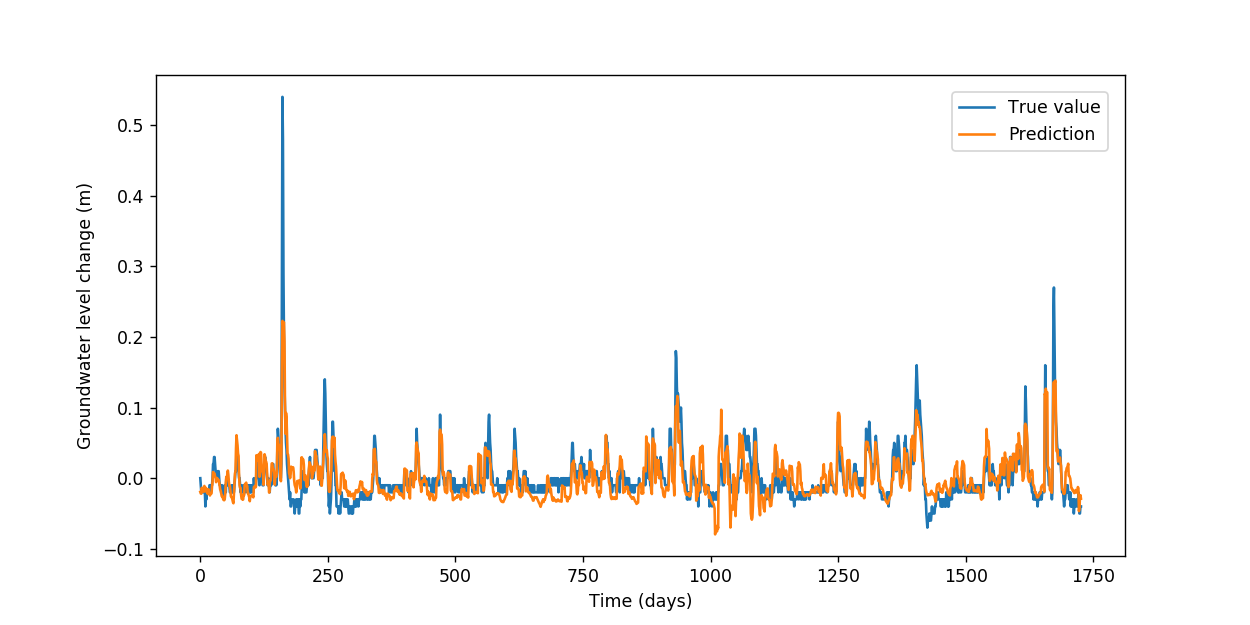

In [835]:
#plot predicted values and real value
fig, ax = plt.subplots(); 
#fig.autofmt_xdate();
fig.set_size_inches(10, 5)
ax.plot(range(len(y)), y, label="True value")
ax.plot(range(len(y)), predicted, label="Prediction");
ax.legend(loc=1, borderaxespad=1)
plt.xlabel('Time (days)')
plt.ylabel('Groundwater level change (m)')
plt.show();

In [836]:
#fig.savefig('./graphs/prediction_'+'id='+ id_n + '_13features' +'.png', dpi=300)

In [837]:
#sum
value = ds['Value']
value = value.values.astype(np.float)[100:]

predicted_value = []
predicted_value.append(value[0])
n=1
for i in predicted[1:]:
    predicted_value.append(predicted_value[n-1] + i)
    n += 1

<IPython.core.display.Javascript object>


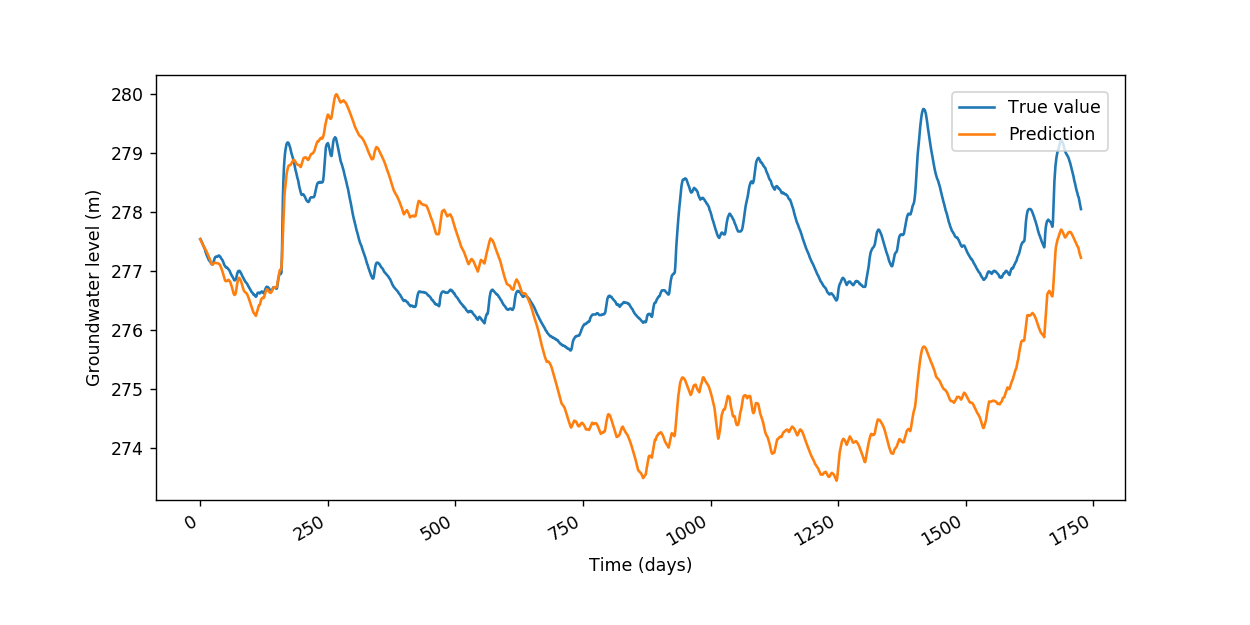

In [838]:
fig, ax = plt.subplots(); fig.autofmt_xdate();
fig.set_size_inches(10, 5)
ax.plot(range(len(value)), value, label="True value");
ax.plot(range(len(value)), predicted_value, label="Prediction");
ax.legend(loc=1, borderaxespad=1)
plt.xlabel('Time (days)')
plt.ylabel('Groundwater level (m)')
plt.show();

In [839]:
#fig.savefig('./graphs/prediction_cum_'+'id='+ id_n + '_13features' +'.png', dpi=300)

In [830]:
#predictin with min and max value
value = ds['Value']
value = value.values.astype(np.float)[100:]
min_value = min(value)
max_value = max(value)

predicted_value2 = []
predicted_value2.append(value[0])
n=1
for i in predicted[1:]:
    if predicted_value2[n-1] + i <= min_value:
        predicted_value2.append(min_value)
    elif predicted_value2[n-1] + i >= max_value:
        predicted_value2.append(max_value)
    else:
        predicted_value2.append(predicted_value2[n-1] + i)
    n += 1

<IPython.core.display.Javascript object>


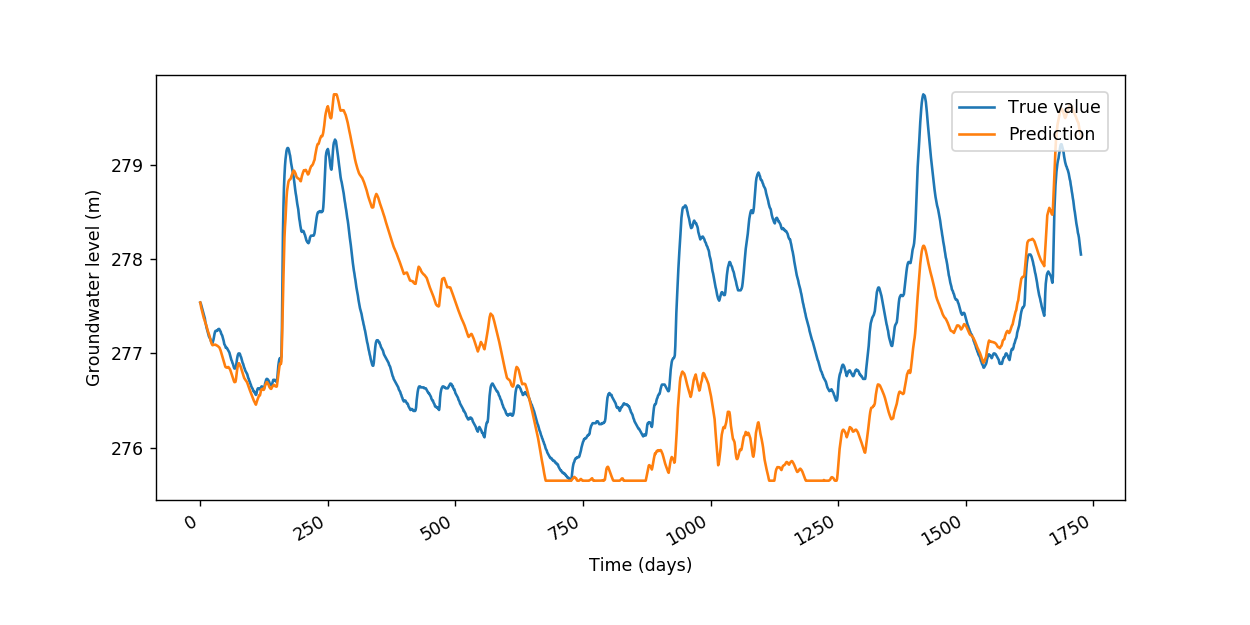

In [840]:
fig, ax = plt.subplots(); fig.autofmt_xdate();
fig.set_size_inches(10, 5)
ax.plot(range(len(value)), value, label="True value");
ax.plot(range(len(value)), predicted_value2, label="Prediction");
ax.legend(loc=1, borderaxespad=1)
plt.xlabel('Time (days)')
plt.ylabel('Groundwater level (m)')
plt.show();

In [841]:
#find epsilon for SVR()
F1_list=[]
s = 1  #step
r0 = 0
r = 10 #range
x = 0.001
for i in range(r0, r, s):
    regressor = SVR(epsilon=i*x);
    predicted2 = cross_val_predict(regressor, X, y, cv = 3)
    mse = mean_squared_error(y, predicted2)
    r2 = r2_score(y, predicted2);
    print(mse, r2)

0.0004561050549915155 0.6721153748116777
0.0004540323400397045 0.6736054073330436
0.0004539334909862309 0.6736764679023001
0.000453544607535722 0.6739560282865068
0.0004509264538507795 0.6758381655929848
0.0004466627157348576 0.6789032799975298
0.00044703827026714593 0.6786333015008883
0.00044968637555482945 0.6767296325978382
0.00044977090409204347 0.6766688667557612
0.000451997643717225 0.6750681090368883
